# XGBoost

In [1]:
import polars as pl
import numpy as np
import xgboost as xgb
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

In [2]:
data_dir = Path.home() / "teams/b13-domain-2/ca_data/"

X_train = pl.scan_parquet(data_dir / "X_train.parquet")
y_train = pl.scan_parquet(data_dir / "y_train.parquet")

X_test = pl.scan_parquet(data_dir / "X_test.parquet")
y_test = pl.scan_parquet(data_dir / "y_test.parquet")

X_validation = pl.scan_parquet(data_dir / "X_validation.parquet")
y_validation = pl.scan_parquet(data_dir / "y_validation.parquet")

## Training

In [3]:
xgb_clf = xgb.XGBClassifier(device="cpu", verbosity=1)

xgb_clf.fit(X_train, y_train)

/home/gwuwong/private/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/xgboost/data.py:928: UserWarning: Using the default parameters for the polars `LazyFrame.collect`. Consider passing a realized `DataFrame` or `Series` instead.
  warnings.warn(


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cpu'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Results

In [3]:
X_train_df = X_train.collect(engine="streaming")
X_test_df = X_test.collect(engine="streaming")
y_train_arr = y_train.collect(engine="streaming").to_numpy().ravel()
y_test_arr = y_test.collect(engine="streaming").to_numpy().ravel()

In [ ]:
y_pred = xgb_clf.predict(X_test_df)
y_pred_proba = xgb_clf.predict_proba(X_test_df)[:, 1]

print(f"\nTrain accuracy: {xgb_clf.score(X_train_df, y_train_arr):.4f}")
print(f"Test accuracy: {xgb_clf.score(X_test_df, y_test_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test_arr, y_pred_proba):.4f}")


Train accuracy: 0.9993
Test accuracy: 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  41980704
           1       0.45      0.18      0.26     28843

    accuracy                           1.00  42009547
   macro avg       0.73      0.59      0.63  42009547
weighted avg       1.00      1.00      1.00  42009547


Confusion Matrix:
[[41974337     6367]
 [   23547     5296]]

ROC-AUC Score: 0.8224

PR-AUC: 0.1820


### Validation

In [4]:
X_validation_df = X_validation.collect(engine="streaming")
y_validation_arr = y_validation.collect(engine="streaming").to_numpy().ravel()

In [ ]:
y_pred = xgb_clf.predict(X_validation_df)
y_pred_proba = xgb_clf.predict_proba(X_validation_df)[:, 1]

print(f"\nValidation accuracy: {xgb_clf.score(X_validation_df, y_validation_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_validation_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_validation_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_validation_arr, y_pred_proba):.4f}")


Validation accuracy: 0.9992

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  35280437
           1       0.02      0.01      0.01     21703

    accuracy                           1.00  35302140
   macro avg       0.51      0.50      0.51  35302140
weighted avg       1.00      1.00      1.00  35302140


Confusion Matrix:
[[35273432     7005]
 [   21542      161]]

ROC-AUC Score: 0.8438

PR-AUC: 0.0075


### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

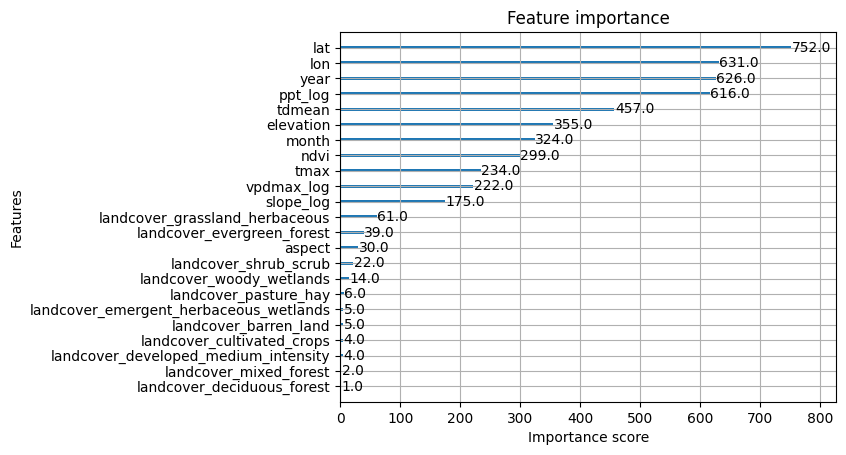

In [6]:
xgb.plot_importance(xgb_clf)

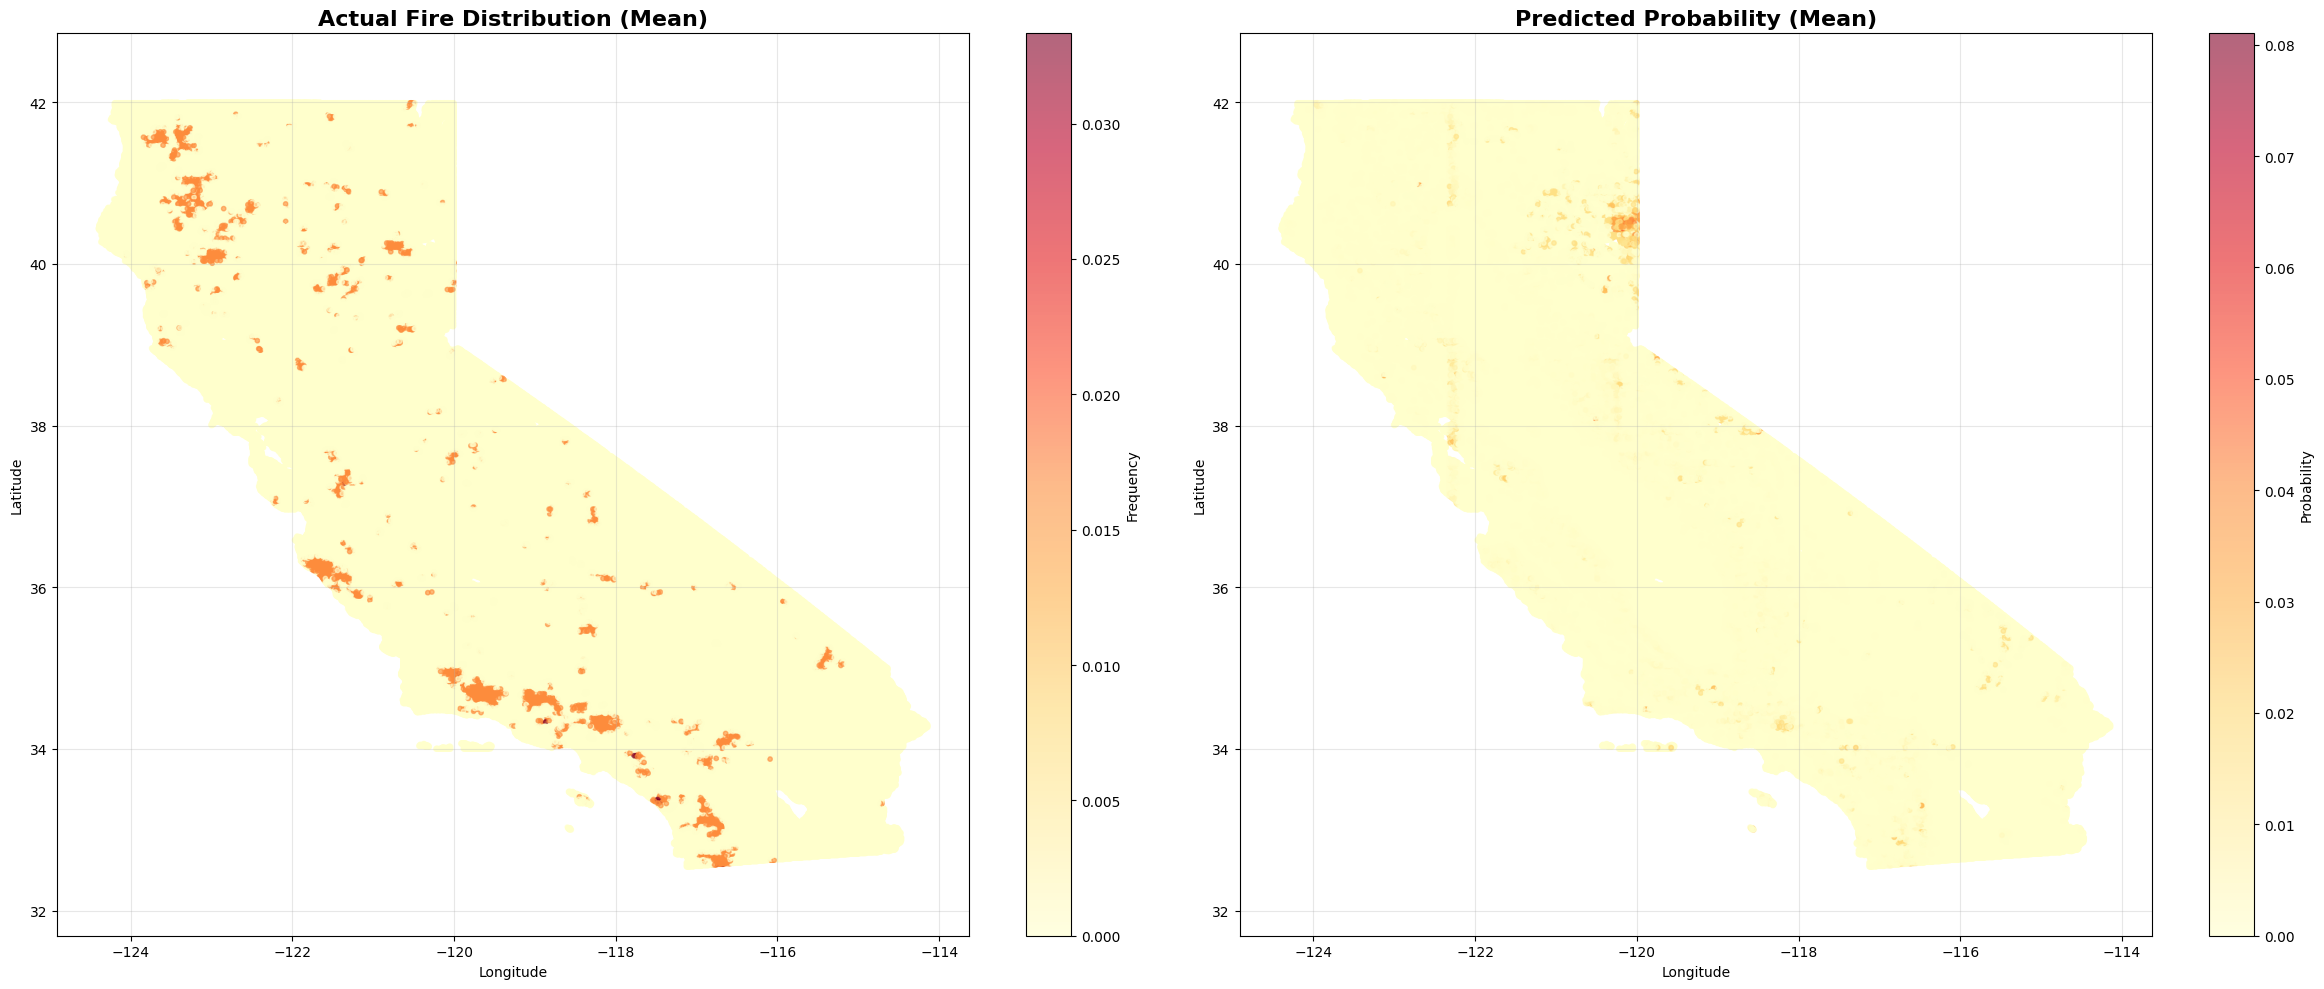

In [7]:
# 1. Prepare data combining coords, actuals, and predictions
# X_validation_df is already a DataFrame from your previous cell
plot_df = X_validation_df.select(['lat', 'lon']).with_columns([
    pl.Series("Actual", y_validation_arr),
    pl.Series("Predicted_Prob", y_pred_proba)
])

# 2. Group by location to get spatial means (handles time dimension if present)
spatial_comp = plot_df.group_by(['lat', 'lon']).agg([
    pl.col("Actual").mean(),
    pl.col("Predicted_Prob").mean()
])

def plot_actual_vs_predict():
    # Since we started with an eager DataFrame (X_validation_df), spatial_comp is also eager.
    # No need to collect.
    data = spatial_comp
    
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # --- Plot 1: Actual ---
    sc1 = axes[0].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Actual'], 
        cmap='YlOrRd',
        s=10, 
        alpha=0.6
    )
    axes[0].set_title("Actual Fire Distribution (Mean)", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    plt.colorbar(sc1, ax=axes[0], label="Frequency")
    
    # --- Plot 2: Predicted Probability ---
    sc2 = axes[1].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Predicted_Prob'], 
        cmap='YlOrRd',
        s=10, 
        alpha=0.6,
        # Helper to ensure color scales match if you want them absolute
    )
    axes[1].set_title("Predicted Probability (Mean)", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    plt.colorbar(sc2, ax=axes[1], label="Probability")
    
    plt.tight_layout()
    plt.show()

plot_actual_vs_predict()

Plotting for 2005-10 (Rows: 588369)


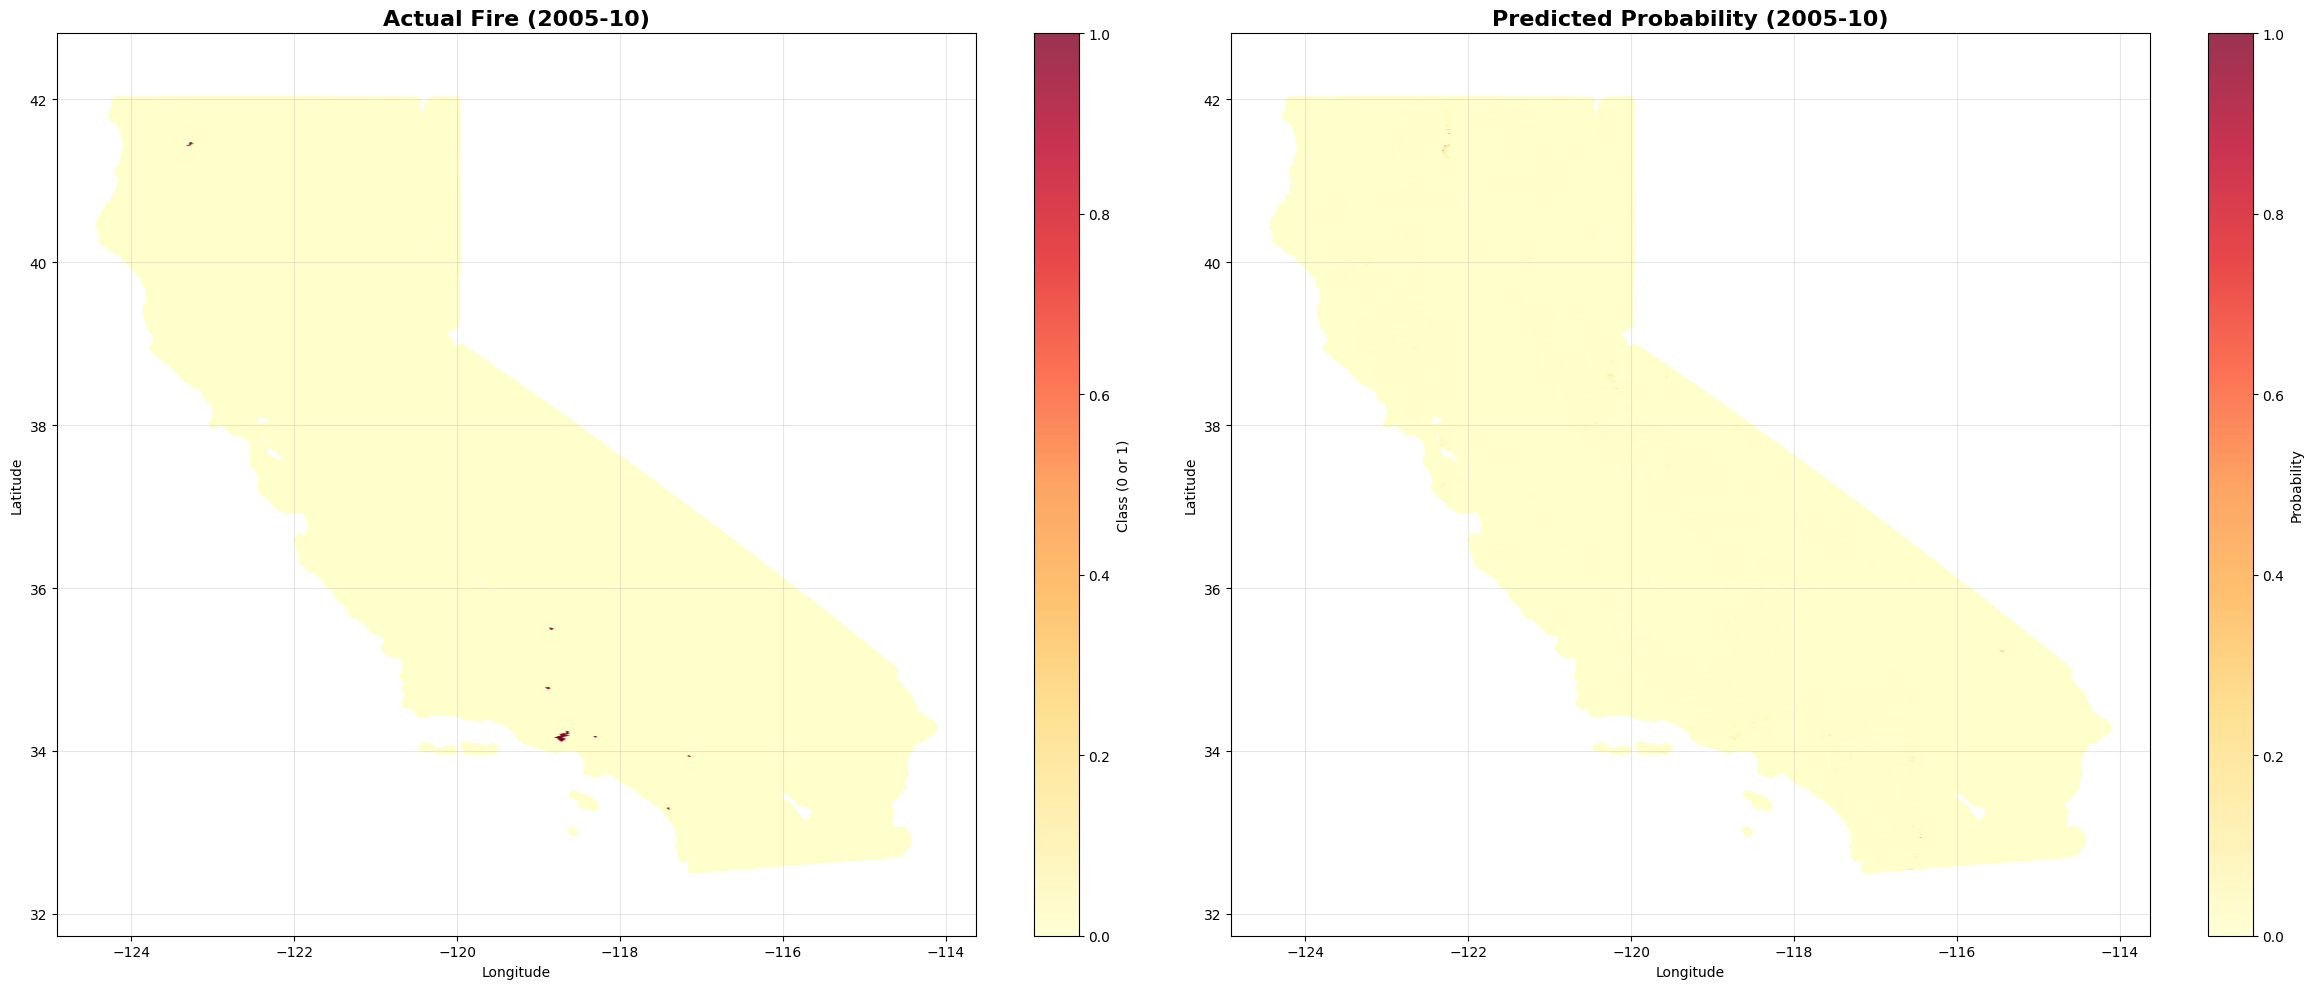

In [8]:
# 1. Prepare data including Year and Month
# Ensure X_validation_df has 'year' and 'month' columns (which it should based on your data)
plot_df = X_validation_df.select(['lat', 'lon', 'year', 'month']).with_columns([
    pl.Series("Actual", y_validation_arr),
    pl.Series("Predicted_Prob", y_pred_proba)
])

def plot_comparison_by_date(target_year, target_month):
    # Filter for the specific year and month
    data = plot_df.filter(
        (pl.col("year") == target_year) & 
        (pl.col("month") == target_month)
    )
    
    if data.height == 0:
        print(f"No data found for {target_year}-{target_month}")
        return

    print(f"Plotting for {target_year}-{target_month} (Rows: {data.height})")

    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Common settings
    extent = [data['lon'].min(), data['lon'].max(), data['lat'].min(), data['lat'].max()]
    
    # --- Plot 1: Actual ---
    sc1 = axes[0].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Actual'], 
        cmap='YlOrRd',
        s=15, 
        alpha=0.8,
        vmin=0, vmax=1 # Fix scale for binary/probability comparison
    )
    axes[0].set_title(f"Actual Fire ({target_year}-{target_month})", fontsize=16, fontweight='bold')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    plt.colorbar(sc1, ax=axes[0], label="Class (0 or 1)")
    
    # --- Plot 2: Predicted Probability ---
    sc2 = axes[1].scatter(
        data['lon'], 
        data['lat'], 
        c=data['Predicted_Prob'], 
        cmap='YlOrRd',
        s=15, 
        alpha=0.8,
        vmin=0, vmax=1 # Fix scale to match Actuals
    )
    axes[1].set_title(f"Predicted Probability ({target_year}-{target_month})", fontsize=16, fontweight='bold')
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    plt.colorbar(sc2, ax=axes[1], label="Probability")
    
    plt.tight_layout()
    plt.show()

# Example usage: Change these values to look at different months
plot_comparison_by_date(2005, 10) 

## Hyperparameter Tuning

In [ ]:
import optuna

def objective(trial):
    param = {
        # "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "n_jobs": -1
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Initialize the specific classifier with params
    clf_trial = xgb.XGBClassifier(**param)
    
    clf_trial.fit(X_train, y_train)
    
    # Predict
    y_pred_proba = clf_trial.predict_proba(X_test_df)[:, 1]
    avg_precision = average_precision_score(y_test_arr, y_pred_proba)

    return avg_precision

# Create and run study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
best_params = best_trial.params
print("Best PR-AUC:", best_trial.value)
print("Best params:", best_params)

/home/gwuwong/private/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-02-08 23:59:53,999] A new study created in memory with name: no-name-9f873cb1-0b9e-4b4a-902b-0abf905c2c0b


/home/gwuwong/private/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/xgboost/data.py:928: UserWarning: Using the default parameters for the polars `LazyFrame.collect`. Consider passing a realized `DataFrame` or `Series` instead.
  warnings.warn(


In [ ]:
from optuna.visualization import plot_intermediate_values
plot_intermediate_values(study)

In [ ]:
final_xgb_clf = xgb.XGBClassifier(**best_params)

final_xgb_clf.fit(X_train, y_train)

In [ ]:
y_pred = final_xgb_clf.predict(X_test_df)
y_pred_proba = final_xgb_clf.predict_proba(X_test_df)[:, 1]

print(f"\nTrain accuracy: {final_xgb_clf.score(X_train_df, y_train_arr):.4f}")
print(f"Test accuracy: {final_xgb_clf.score(X_test_df, y_test_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test_arr, y_pred_proba):.4f}")

In [ ]:
y_pred = final_xgb_clf.predict(X_validation_df)
y_pred_proba = final_xgb_clf.predict_proba(X_validation_df)[:, 1]

print(f"\nValidation accuracy: {final_xgb_clf.score(X_validation_df, y_validation_arr):.4f}")

print("\nClassification Report:")
print(classification_report(y_validation_arr, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation_arr, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_validation_arr, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_validation_arr, y_pred_proba):.4f}")